# Multi-class model tests

In [1]:
import torch
from collections import namedtuple
from utils import dataset_cached as dc
from utils import multiclass_dataset_cached as mdc
from torchvision.utils import make_grid, save_image
from tqdm import tqdm
from utils.dataset_cached import CELEBA_EASY_LABELS
from utils.multiclass_dataset_cached import CELEBA_MULTI_LABELS, CELEBACached
from models.ccvae import CCVAE, mc_CCVAE
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL
import os


### Loading

In [2]:
NUM_MC_LABELS = 1

In [3]:
# change root for mutlilabel (already dropped the nans within celebaCached)
mc_loaders = mdc.setup_data_loaders(False,
                                      200,
                                      cache_data=True,
                                      sup_frac=0.1,
                                      root='./data/datasets/celeba',
                                      multi_class=True)



Loading MULTI_CLASS dataset
Splitting Dataset
Loading MULTI_CLASS dataset
Loading MULTI_CLASS dataset
Loading MULTI_CLASS dataset


In [4]:

z_dim = 43 # To keep 27 dimensions for z\c and one per label (16 labels in the multi-class label setting)
im_shape = (3, 64, 64)
num_binary_classes = len(CELEBA_MULTI_LABELS)-1
num_mc_labels = 1
num_mc_classes = 5

mc_cc_vae = mc_CCVAE(z_dim=z_dim,
                   num_binary_classes=num_binary_classes,
                   im_shape=im_shape,
                   use_cuda=False,
                   num_mc_labels = num_mc_labels,
                   num_mc_classes = num_mc_classes)

In [5]:
ENCODER_PATH = './pretrained_weights/weights_f90_80epoch_mc/encoder.pt'
DECODER_PATH = './pretrained_weights/weights_f90_80epoch_mc/decoder.pt'
COND_PRIOR_BIN_PATH = './pretrained_weights/weights_f90_80epoch_mc/cond_prior_binary.pt'
CLASSIFIER_BIN_PATH = './pretrained_weights/weights_f90_80epoch_mc/classifier_binary.pt'
COND_PRIOR_MC_PATH = './pretrained_weights/weights_f90_80epoch_mc/cond_prior_mc.pt'
CLASSIFIER_MC_PATH = './pretrained_weights/weights_f90_80epoch_mc/classifier_mc.pt'

In [6]:

# Load weights for the encoder
encoder_checkpoint = torch.load(ENCODER_PATH)
mc_cc_vae.encoder.load_state_dict(encoder_checkpoint.state_dict())

# Load weights for the decoder
decoder_checkpoint = torch.load(DECODER_PATH)
mc_cc_vae.decoder.load_state_dict(decoder_checkpoint.state_dict())

# Load weights for the classifier
classifier_binary_checkpoint = torch.load(CLASSIFIER_BIN_PATH)
mc_cc_vae.classifier_binary.load_state_dict(classifier_binary_checkpoint.state_dict())

# Load weights for the conditional prior
cond_prior_binary_checkpoint = torch.load(COND_PRIOR_BIN_PATH)
mc_cc_vae.cond_prior_binary.load_state_dict(cond_prior_binary_checkpoint.state_dict())

# Load weights for the classifier
classifier_mc_checkpoint = torch.load(CLASSIFIER_MC_PATH)
mc_cc_vae.classifier_mc.load_state_dict(classifier_mc_checkpoint.state_dict())

# Load weights for the conditional prior
cond_prior_mc_checkpoint = torch.load(COND_PRIOR_MC_PATH)
mc_cc_vae.cond_prior_mc.load_state_dict(cond_prior_mc_checkpoint.state_dict())



<All keys matched successfully>

In [7]:
# Make sure to set each component to evaluation mode if needed
mc_cc_vae.encoder.eval()
mc_cc_vae.decoder.eval()
mc_cc_vae.classifier_binary.eval()
mc_cc_vae.cond_prior_binary.eval()
mc_cc_vae.classifier_mc.eval()
mc_cc_vae.cond_prior_mc.eval()

CondPrior_mc(
  (diag_loc): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1]
      (1): Parameter containing: [torch.float32 of size 1]
      (2): Parameter containing: [torch.float32 of size 1]
      (3): Parameter containing: [torch.float32 of size 1]
      (4): Parameter containing: [torch.float32 of size 1]
  )
  (diag_scale): ParameterList(
      (0): Parameter containing: [torch.float32 of size 1]
      (1): Parameter containing: [torch.float32 of size 1]
      (2): Parameter containing: [torch.float32 of size 1]
      (3): Parameter containing: [torch.float32 of size 1]
      (4): Parameter containing: [torch.float32 of size 1]
  )
)

## Inference :

**Reconstruct Images**

In [8]:
img_batch = CELEBACached.fixed_imgs
reconstructed_img_batch = mc_cc_vae.reconstruct_img(img_batch).view(-1, *im_shape)

In [9]:

img_idx =5
img = img_batch[img_idx,:,:,:]
reconstructed_img = reconstructed_img_batch[img_idx,:,:,:]

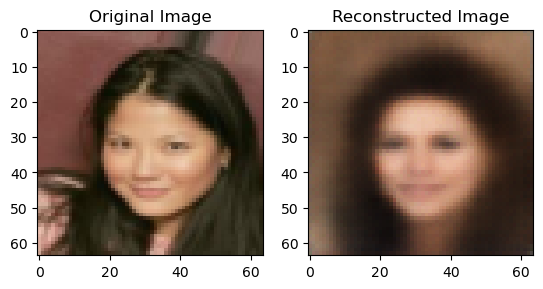

In [10]:
to_pil = transforms.ToPILImage()
image_pil = to_pil(img)
reconstructed_pil = to_pil(reconstructed_img)

# Plot the original image on the left
plt.subplot(1, 2, 1)
plt.imshow(image_pil)
plt.title('Original Image')

# Plot the reconstructed image on the right
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_pil)
plt.title('Reconstructed Image')

# Display the plots
plt.show()



## Latent traversal tests

In [11]:
mc_cc_vae.mc_latent_walk(img, '/Users/Hippolyte/Desktop/P1/PGM/ccvae_pytorch/data/image_mc2')

Label : Bald
Mean of the Gaussian :  tensor([[0.3139]], grad_fn=<ViewBackward0>)
Variance of the Gaussian :  tensor([[0.8639]], grad_fn=<ClampBackward1>)
Label : Black_Hair
Mean of the Gaussian :  tensor([[0.7913]], grad_fn=<ViewBackward0>)
Variance of the Gaussian :  tensor([[0.9958]], grad_fn=<ClampBackward1>)
Label : Blond_Hair
Mean of the Gaussian :  tensor([[0.8404]], grad_fn=<ViewBackward0>)
Variance of the Gaussian :  tensor([[1.1900]], grad_fn=<ClampBackward1>)
Label : Brown_Hair
Mean of the Gaussian :  tensor([[0.5333]], grad_fn=<ViewBackward0>)
Variance of the Gaussian :  tensor([[0.8871]], grad_fn=<ClampBackward1>)
Label : Gray_Hair
Mean of the Gaussian :  tensor([[0.5396]], grad_fn=<ViewBackward0>)
Variance of the Gaussian :  tensor([[0.9488]], grad_fn=<ClampBackward1>)
